The task is to build a sentiment analysis model using Tensorflow.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
# download the dataset: airline tweets
# original dataset on Kaggle: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
# save the dataset in Pandas dataframe
df = pd.read_csv('AirlineTweets.csv')

In [4]:
df = df[['airline_sentiment', 'text']]

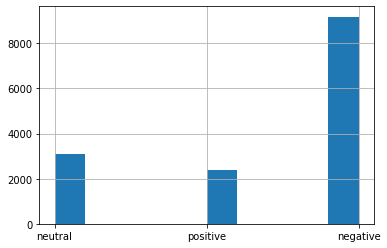

In [5]:
# check the sentiment distribution: it looks imbalanced
df['airline_sentiment'].hist()

In [6]:
# leave out the neutral tweets
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [7]:
# assign integers to sentiment classes
target_map = {'positive': 1, 'negative': 0}
df['sentiment_class'] = df['airline_sentiment'].map(target_map)

In [8]:
df.head()

,airline_sentiment,text,sentiment_class
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [9]:
# make train and test sets
df_train, df_test = train_test_split(df)

In [10]:
# use TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [11]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [12]:
Y_train = df_train['sentiment_class']
Y_test = df_test['sentiment_class']

In [13]:
# input dimensions
D = X_train.shape[1]

In [14]:
# build a model
i = Input(shape=(D,))
x = Dense(1)(i)

model = Model(i, x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [17]:
r = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=128)

Epoch 1/40
68/68 [==============================] - 1s 4ms/step - loss: 0.4997 - accuracy: 0.7978 - val_loss: 0.4164 - val_accuracy: 0.7876
Epoch 2/40
68/68 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8017 - val_loss: 0.3578 - val_accuracy: 0.8001
Epoch 3/40
68/68 [==============================] - 0s 2ms/step - loss: 0.3193 - accuracy: 0.8217 - val_loss: 0.3179 - val_accuracy: 0.8236
Epoch 4/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.8495 - val_loss: 0.2906 - val_accuracy: 0.8416
Epoch 5/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2554 - accuracy: 0.8656 - val_loss: 0.2710 - val_accuracy: 0.8590
Epoch 6/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.8811 - val_loss: 0.2558 - val_accuracy: 0.8725
Epoch 7/40
68/68 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.8946 - val_loss: 0.2442 - val_accuracy: 0.8839
Epoch 8/40
68/68 [==

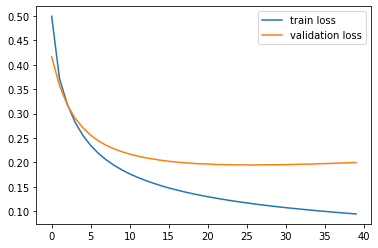

In [18]:
# loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()

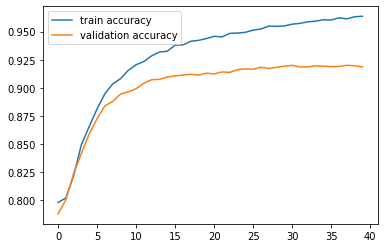

In [19]:
# aacuracy per iteration
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()

In [20]:
# make predictions
p_train = ((model.predict(X_train) > 0) * 1.0).flatten()
p_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 718us/step


In [21]:
# make confusion matrix for the train set
cm = confusion_matrix(Y_train, p_train, normalize='true')
cm

array([[0.98942795, 0.01057205],
       [0.09885714, 0.90114286]])

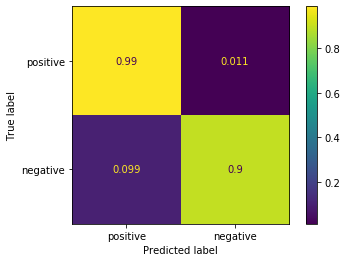

In [22]:
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative'])
cm_plot.plot()

In [23]:
# make confusion matrix for the test set
cm_test = confusion_matrix(Y_test, p_test, normalize='true')
cm_test

array([[0.96260449, 0.03739551],
       [0.25285481, 0.74714519]])

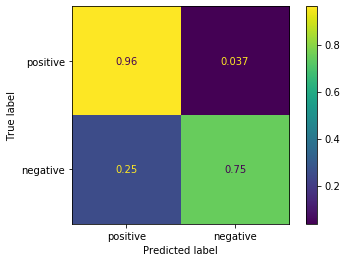

In [24]:
cm_test_plot = ConfusionMatrixDisplay(cm_test, display_labels=['positive', 'negative'])
cm_test_plot.plot()

In [25]:
# calculate AUC score and F1 score
pr_train = model.predict(X_train)
pr_test = model.predict(X_test)
print('Train AUC', roc_auc_score(Y_train, pr_train))
print('Test AUC', roc_auc_score(Y_test, pr_test))

91/91 [==============================] - 0s 630us/step
Train AUC 0.994699824143995
Test AUC 0.9568927095795813


In [26]:
print('Train F1', f1_score(Y_train, p_train))
print('Test F1', f1_score(Y_test, p_test))

Train F1 0.9276470588235295
Test F1 0.7923875432525952


In [27]:
w = model.layers[1].get_weights()[0]

In [28]:
word_index_map = vectorizer.vocabulary_

In [29]:
# print positive and negative words
def print_top_words(positive=True, threshold=2):
    sentiment = 'positive' if positive else 'negative'
    print(f"Most {sentiment} words:")
    word_weight_tuples_pos = []
    word_weight_tuples_neg = []
    for word, index in word_index_map.items():
        weight = w[index, 0]
        if weight > threshold:
            word_weight_tuples_pos.append((word, weight))
        elif weight < -threshold:
            word_weight_tuples_neg.append((word, weight))
    word_weight_tuples_pos = sorted(word_weight_tuples_pos, key=lambda x: -x[1])
    word_weight_tuples_neg = sorted(word_weight_tuples_neg, key=lambda x: x[1])
    for i in range(10):
        word, weight = word_weight_tuples_pos[i] if positive else word_weight_tuples_neg[i]
        print(word, weight)

In [30]:
print_top_words(positive=True)

Most positive words:
thank 9.260481
thanks 9.023598
great 7.899902
love 7.419631
amazing 7.3667574
awesome 6.7656317
kudos 6.738107
wonderful 6.373736
excellent 5.8526034
best 5.58446


In [31]:
print_top_words(positive=False)

Most negative words:
worst -9.533064
paid -7.649934
rude -7.3315744
disappointed -7.277403
not -7.0899262
pay -6.9319305
delayed -6.780027
hours -6.693833
terrible -6.5821643
stranded -6.5397744
